<a href="https://colab.research.google.com/github/DeepaManjunath/Assignment5-New/blob/master/RangeTest_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q '/content/gdrive/My Drive/EIP4/hvc_data.zip'
# look for `hvc_annotations.csv` file and `resized` dir
%ls '/content/gdrive/My Drive/EIP4/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
hvc_data/  hvc_data.zip  SaveModel/  train.csv  val.csv


In [2]:
%tensorflow_version 1.x
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation , Dropout
from keras.layers import AveragePooling2D, Input, Flatten ,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:

# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
#one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.01, s_h=0.2, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.batch_size = batch_size
        #self.labels = labels
        #self.list_IDs = list_IDs
        #self.n_channels = n_channels
        #self.n_classes = n_classes
        #self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation=augmentation
        
        
        #self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

            
    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        if self.augmentation is not None:
           images=self.augmentation.flow(images,shuffle=False).next()
           
        target = {
                       "gender_output": items[_gender_cols_].values,
                       "image_quality_output": items[_imagequality_cols_].values,
                       "age_output": items[_age_cols_].values,
                       "weight_output": items[_weight_cols_].values,
                       "bag_output": items[_carryingbag_cols_].values,
                       "pose_output": items[_bodypose_cols_].values,
                       "footwear_output": items[_footwear_cols_].values,
                       "emotion_output": items[_emotion_cols_].values,
        }
        return images, target
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
  

In [7]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,random_state=17)
train_df.shape, val_df.shape


((11537, 28), (2036, 28))

In [8]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
9640,resized/9641.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1
1977,resized/1978.jpg,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
3685,resized/3686.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
13072,resized/13074.jpg,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
11425,resized/11427.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0


In [0]:
#create train and validation data generators
train_gen = PersonDataGenerator(train_df,batch_size=32,
                                augmentation=ImageDataGenerator(rescale=1./255,width_shift_range=0.1,
	                                                              height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	                                                              horizontal_flip=True, fill_mode="nearest", 
                                                                rotation_range=25,preprocessing_function=get_random_eraser(v_l=0, v_h=1)                                                                 
	                                                                                  ))
                       
                                                            
	                                                                                      

                             
                                                        
                                                          



#train_gen = PersonDataGenerator(train_df, batch_size=32,augmentation=True)
                                
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False,
                                augmentation=ImageDataGenerator(rescale=1./255))


In [10]:
# get number of output units from data
images, targets = next(iter(valid_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [11]:
#from classification_models.resnet import ResNet18, preprocess_input
import keras.applications.resnet 
from keras.applications.inception_v3 import InceptionV3

from keras.applications.resnet import ResNet50

backbone = InceptionV3(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

  


neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = BatchNormalization(momentum=0.355)(in_layer)
    neck = Dropout(0.092)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization(momentum=0.355)(in_layer)
    neck = Dropout(0.092)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = BatchNormalization(momentum=0.355)(in_layer)
    neck = Dropout(0.092)(in_layer)
    neck = Dense(28, activation="relu")(neck)
    
    
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="sigmoid",name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=5.625, epochs=24):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [13]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "binary_crossentropy",
 	"age_output": "binary_crossentropy",
 	"weight_output": "binary_crossentropy",
  "bag_output": "binary_crossentropy",
  "pose_output": "binary_crossentropy",
  "footwear_output": "binary_crossentropy",   
  "emotion_output": "binary_crossentropy",
       

 }
loss_weights = {"gender_output": 0.1, "image_quality_output": 0.1, "age_output": 0.1, "weight_output": 0.1,"bag_output":0.1,"pose_output":0.1,"footwear_output":0.1,"emotion_output":0.1}
model.summary()
LRFind=LRFinder(min_lr=1e-5, max_lr=10, steps_per_epoch=(2036//32), epochs=50)
opt = SGD(lr=0.01427,momentum=0.9)

import os
from keras.models import Model
# Prepare model model saving directory.
save_dir = '/content/gdrive/My Drive/EIP4/SaveModel'
filepath = '/content/gdrive/My Drive/EIP4/SaveModel/model100.h5'

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True)
callbacks = [checkpoint,LRFind]


model.compile(
    optimizer=opt,
    loss="binary_crossentropy", 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________



Epoch 1/1
360/360 [==============================] - 165s 459ms/step - loss: 0.4388 - gender_output_loss: 0.6934 - image_quality_output_loss: 0.5939 - age_output_loss: 0.4781 - weight_output_loss: 0.4430 - bag_output_loss: 0.5672 - footwear_output_loss: 0.6242 - pose_output_loss: 0.5751 - emotion_output_loss: 0.4130 - gender_output_acc: 0.5502 - image_quality_output_acc: 0.6934 - age_output_acc: 0.7930 - weight_output_acc: 0.8128 - bag_output_acc: 0.7008 - footwear_output_acc: 0.6583 - pose_output_acc: 0.7312 - emotion_output_acc: 0.8497 - val_loss: 0.4244 - val_gender_output_loss: 0.6849 - val_image_quality_output_loss: 0.5763 - val_age_output_loss: 0.4588 - val_weight_output_loss: 0.4228 - val_bag_output_loss: 0.5507 - val_footwear_output_loss: 0.6064 - val_pose_output_loss: 0.5403 - val_emotion_output_loss: 0.4032 - val_gender_output_acc: 0.5650 - val_image_quality_output_acc: 0.7017 - val_age_output_acc: 0.8000 - val_weight_output_acc: 0.8172 - val_bag_output_acc: 0.7070 - val_fo

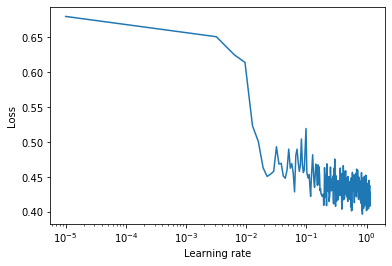

In [14]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    workers=4, 
    epochs=1,
    verbose=1,
    callbacks=callbacks
    )
LRFind.plot_loss()
